# **SECTION 1: SETUP AND IMPORTS**
**Install required libraries and import necessary modules**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# **SECTION 2: TRANSFORMER DECODER ARCHITECTURE**

**Core implementation with causal masking and attention mechanisms**

In [3]:
class MultiHeadAttention(nn.Module):
    """Fixed multi-head attention with separate Q, K, V"""
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        # Separate linear layers for Q, K, V
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        # Linear projections
        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attention = torch.softmax(scores, dim=-1)
        out = torch.matmul(attention, V)

        # Concatenate heads
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.fc_out(out)


class FeedForward(nn.Module):
    """Position-wise feed-forward network"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(torch.relu(self.fc1(x))))


class EncoderLayer(nn.Module):
    """Encoder layer with self-attention"""
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x


class DecoderLayer(nn.Module):
    """Corrected decoder layer with proper cross-attention"""
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Self-attention with causal mask
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Cross-attention: Query from decoder, Key/Value from encoder
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))

        # Feed-forward
        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x


class TransformerDecoder(nn.Module):
    """Complete Transformer with encoder-decoder architecture"""
    def __init__(self, vocab_size, d_model=256, num_heads=8, num_layers=3,
                 d_ff=512, dropout=0.1, max_len=128):
        super().__init__()
        self.d_model = d_model

        # Embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = self._generate_positional_encoding(max_len, d_model)

        # Encoder
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Decoder
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def _generate_positional_encoding(self, max_len, d_model):
        """Sinusoidal positional encoding"""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        return pe.unsqueeze(0)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Encoder
        src_emb = self.dropout(self.embedding(src) * math.sqrt(self.d_model))
        src_emb = src_emb + self.pos_encoding[:, :src.size(1), :].to(src.device)

        enc_output = src_emb
        for layer in self.encoder_layers:
            enc_output = layer(enc_output, src_mask)

        # Decoder
        tgt_emb = self.dropout(self.embedding(tgt) * math.sqrt(self.d_model))
        tgt_emb = tgt_emb + self.pos_encoding[:, :tgt.size(1), :].to(tgt.device)

        dec_output = tgt_emb
        for layer in self.decoder_layers:
            dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)

        return self.fc_out(dec_output)


def create_causal_mask(size, device):
    """Create causal mask to prevent attending to future tokens"""
    mask = torch.tril(torch.ones(size, size, device=device))
    return mask.unsqueeze(0).unsqueeze(0)


def create_padding_mask(seq, pad_token_id):
    """Create padding mask"""
    return (seq != pad_token_id).unsqueeze(1).unsqueeze(2)

# **SECTION 3: DATA PREPARATION**

**Load and preprocess dataset for sequence-to-sequence task**

In [4]:
class TranslationDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=64):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = self.data[idx]['translation']['en']
        tgt_text = self.data[idx]['translation']['de']

        src = self.tokenizer.encode(src_text, max_length=self.max_len,
                                     truncation=True, padding='max_length',
                                     return_tensors='pt').squeeze(0)
        tgt = self.tokenizer.encode(tgt_text, max_length=self.max_len,
                                     truncation=True, padding='max_length',
                                     return_tensors='pt').squeeze(0)

        return src, tgt


print("\nLoading dataset...")
# CONFIGURATION: Adjust these parameters based on your compute resources
# For quick testing: 10000 samples (~30 min training)
# For better results: 50000 samples (~2-3 hours training)
# For production quality: 100000+ samples (~6+ hours training)

TRAINING_SAMPLES = 50000
VALIDATION_SAMPLES = 1000

print(f"📊 Using {TRAINING_SAMPLES:,} training samples")
print(f"   (Change TRAINING_SAMPLES variable to use more data)")

dataset = load_dataset('wmt14', 'de-en', split=f'train[:{TRAINING_SAMPLES}]')
val_dataset = load_dataset('wmt14', 'de-en', split=f'validation[:{VALIDATION_SAMPLES}]')

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TranslationDataset(dataset, tokenizer)
val_dataset = TranslationDataset(val_dataset, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Adjusted for larger dataset
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")



Loading dataset...
📊 Using 50,000 training samples
   (Change TRAINING_SAMPLES variable to use more data)


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

de-en/train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

de-en/train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

de-en/validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

de-en/test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training samples: 50000
Validation samples: 1000


# **SECTION 4: MODEL TRAINING**

**Train the transformer decoder with proper loss and optimization**


Model parameters: 19,611,450

Starting training...


Training: 100%|██████████| 3125/3125 [03:03<00:00, 17.01it/s]


Epoch 1/40 - Train: 4.6787, Val: 5.1799 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.88it/s]


Epoch 2/40 - Train: 3.9910, Val: 4.9920 ✓ SAVED


Training: 100%|██████████| 3125/3125 [03:16<00:00, 15.94it/s]


Epoch 3/40 - Train: 3.7744, Val: 4.8730 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.84it/s]


Epoch 4/40 - Train: 3.6472, Val: 4.8056 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:56<00:00, 17.74it/s]


Epoch 5/40 - Train: 3.5588, Val: 4.7650 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.77it/s]


Epoch 6/40 - Train: 3.4916, Val: 4.7202 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:56<00:00, 17.70it/s]


Epoch 7/40 - Train: 3.4380, Val: 4.6982 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.91it/s]


Epoch 8/40 - Train: 3.3924, Val: 4.6990


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.92it/s]


Epoch 9/40 - Train: 3.3556, Val: 4.6805 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.96it/s]


Epoch 10/40 - Train: 3.3237, Val: 4.6393 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.92it/s]


Epoch 11/40 - Train: 3.2946, Val: 4.6493


Training: 100%|██████████| 3125/3125 [02:53<00:00, 17.98it/s]


Epoch 12/40 - Train: 3.2695, Val: 4.6322 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:53<00:00, 17.97it/s]


Epoch 13/40 - Train: 3.2471, Val: 4.6134 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.92it/s]


Epoch 14/40 - Train: 3.2256, Val: 4.6243


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.94it/s]


Epoch 15/40 - Train: 3.2059, Val: 4.6020 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.86it/s]


Epoch 16/40 - Train: 3.1884, Val: 4.6164


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.87it/s]


Epoch 17/40 - Train: 3.1733, Val: 4.6057


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.81it/s]


Epoch 18/40 - Train: 3.1581, Val: 4.6015 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.78it/s]


Epoch 19/40 - Train: 3.1442, Val: 4.5959 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.87it/s]


Epoch 20/40 - Train: 3.1311, Val: 4.5873 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.89it/s]


Epoch 21/40 - Train: 3.1192, Val: 4.5783 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.92it/s]


Epoch 22/40 - Train: 3.1079, Val: 4.5706 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.90it/s]


Epoch 23/40 - Train: 3.0959, Val: 4.5853


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.88it/s]


Epoch 24/40 - Train: 3.0863, Val: 4.5840


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.83it/s]


Epoch 25/40 - Train: 3.0755, Val: 4.5843


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.78it/s]


Epoch 26/40 - Train: 2.9964, Val: 4.5577 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.86it/s]


Epoch 27/40 - Train: 2.9735, Val: 4.5569 ✓ SAVED


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.79it/s]


Epoch 28/40 - Train: 2.9622, Val: 4.5621


Training: 100%|██████████| 3125/3125 [02:54<00:00, 17.89it/s]


Epoch 29/40 - Train: 2.9534, Val: 4.5677


Training: 100%|██████████| 3125/3125 [02:55<00:00, 17.82it/s]


Epoch 30/40 - Train: 2.9462, Val: 4.5736


Training: 100%|██████████| 3125/3125 [02:56<00:00, 17.66it/s]


Epoch 31/40 - Train: 2.9020, Val: 4.5687


Training: 100%|██████████| 3125/3125 [02:56<00:00, 17.74it/s]


Epoch 32/40 - Train: 2.8911, Val: 4.5681

Early stopping triggered after 32 epochs


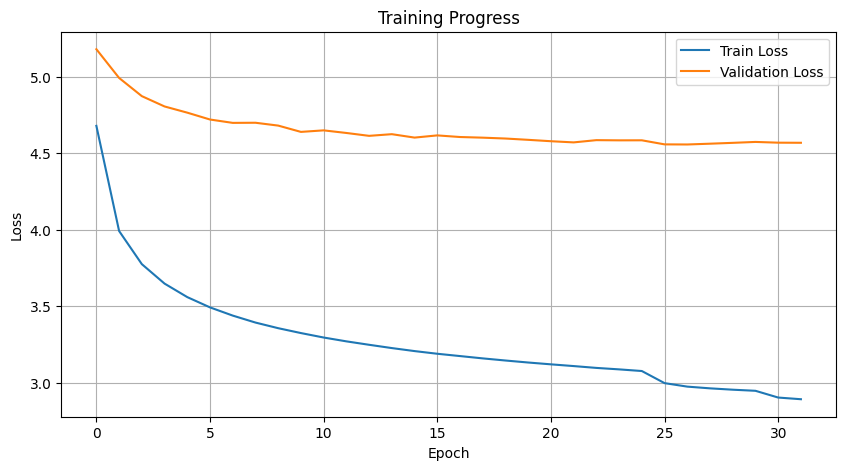

In [5]:
vocab_size = tokenizer.vocab_size
model = TransformerDecoder(
    vocab_size=vocab_size,
    d_model=256,
    num_heads=8,
    num_layers=3,
    d_ff=512,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01, betas=(0.9, 0.98))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for src, tgt in tqdm(loader, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        # Create masks
        tgt_mask = create_causal_mask(tgt_input.size(1), device)
        src_mask = create_padding_mask(src, tokenizer.pad_token_id).to(device)

        optimizer.zero_grad()
        output = model(src, tgt_input, src_mask, tgt_mask)

        loss = criterion(output.reshape(-1, vocab_size), tgt_output.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            tgt_mask = create_causal_mask(tgt_input.size(1), device)
            src_mask = create_padding_mask(src, tokenizer.pad_token_id).to(device)

            output = model(src, tgt_input, src_mask, tgt_mask)
            loss = criterion(output.reshape(-1, vocab_size), tgt_output.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(loader)


# Training loop - IMPROVED VERSION
num_epochs = 40  # More epochs for better convergence
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
patience_counter = 0

print("\nStarting training...")
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f} ✓ SAVED")
    else:
        patience_counter += 1
        print(f"Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.4f}, Val: {val_loss:.4f}")

    # Early stopping
    if patience_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# **SECTION 5: DECODING STRATEGIES**
**Description: Implement greedy, beam search, and nucleus sampling**

In [9]:
def greedy_decode(model, src, max_len, start_token, end_token, device):
    """Greedy decoding: select most probable token"""
    model.eval()
    src = src.to(device)

    with torch.no_grad():
        # Encode source
        src_mask = create_padding_mask(src, tokenizer.pad_token_id).to(device)
        src_emb = model.dropout(model.embedding(src) * math.sqrt(model.d_model))
        src_emb = src_emb + model.pos_encoding[:, :src.size(1), :].to(device)

        enc_output = src_emb
        for layer in model.encoder_layers:
            enc_output = layer(enc_output, src_mask)

        # Decode
        output = torch.tensor([[start_token]], device=device)

        for _ in range(max_len):
            tgt_mask = create_causal_mask(output.size(1), device)

            tgt_emb = model.dropout(model.embedding(output) * math.sqrt(model.d_model))
            tgt_emb = tgt_emb + model.pos_encoding[:, :output.size(1), :].to(device)

            dec_output = tgt_emb
            for layer in model.decoder_layers:
                dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)

            logits = model.fc_out(dec_output[:, -1, :])
            next_token = logits.argmax(dim=-1).unsqueeze(0)

            output = torch.cat([output, next_token], dim=1)

            if next_token.item() == end_token:
                break

        return output.squeeze(0).tolist()


def beam_search_decode(model, src, max_len, start_token, end_token, beam_width, device):
    """Beam search decoding"""
    model.eval()
    src = src.to(device)

    with torch.no_grad():
        # Encode source
        src_mask = create_padding_mask(src, tokenizer.pad_token_id).to(device)
        src_emb = model.dropout(model.embedding(src) * math.sqrt(model.d_model))
        src_emb = src_emb + model.pos_encoding[:, :src.size(1), :].to(device)

        enc_output = src_emb
        for layer in model.encoder_layers:
            enc_output = layer(enc_output, src_mask)

        # Initialize beams
        beams = [(torch.tensor([[start_token]], device=device), 0.0)]

        for _ in range(max_len):
            new_beams = []

            for seq, score in beams:
                if seq[0, -1].item() == end_token:
                    new_beams.append((seq, score))
                    continue

                tgt_mask = create_causal_mask(seq.size(1), device)

                tgt_emb = model.dropout(model.embedding(seq) * math.sqrt(model.d_model))
                tgt_emb = tgt_emb + model.pos_encoding[:, :seq.size(1), :].to(device)

                dec_output = tgt_emb
                for layer in model.decoder_layers:
                    dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)

                logits = model.fc_out(dec_output[:, -1, :])
                log_probs = torch.log_softmax(logits, dim=-1)

                top_log_probs, top_indices = torch.topk(log_probs, beam_width)

                for log_prob, idx in zip(top_log_probs[0], top_indices[0]):
                    new_seq = torch.cat([seq, idx.unsqueeze(0).unsqueeze(0)], dim=1)
                    new_score = score + log_prob.item()
                    new_beams.append((new_seq, new_score))

            # Keep top beam_width sequences
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

            if all(b[0][0, -1].item() == end_token for b in beams):
                break

        best_seq = beams[0][0]
        return best_seq.squeeze(0).tolist()


def nucleus_sampling_decode(model, src, max_len, start_token, end_token, p, temperature, device):
    """Nucleus (top-p) sampling"""
    model.eval()
    src = src.to(device)

    with torch.no_grad():
        # Encode source
        src_mask = create_padding_mask(src, tokenizer.pad_token_id).to(device)
        src_emb = model.dropout(model.embedding(src) * math.sqrt(model.d_model))
        src_emb = src_emb + model.pos_encoding[:, :src.size(1), :].to(device)

        enc_output = src_emb
        for layer in model.encoder_layers:
            enc_output = layer(enc_output, src_mask)

        # Decode
        output = torch.tensor([[start_token]], device=device)

        for _ in range(max_len):
            tgt_mask = create_causal_mask(output.size(1), device)

            tgt_emb = model.dropout(model.embedding(output) * math.sqrt(model.d_model))
            tgt_emb = tgt_emb + model.pos_encoding[:, :output.size(1), :].to(device)

            dec_output = tgt_emb
            for layer in model.decoder_layers:
                dec_output = layer(dec_output, enc_output, src_mask, tgt_mask)

            logits = model.fc_out(dec_output[:, -1, :]) / temperature
            probs = torch.softmax(logits, dim=-1)

            # Nucleus sampling
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)
            cumsum_probs = torch.cumsum(sorted_probs, dim=-1)

            # Remove tokens with cumulative probability above threshold
            sorted_indices_to_remove = cumsum_probs > p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            sorted_probs[sorted_indices_to_remove] = 0
            sorted_probs = sorted_probs / sorted_probs.sum()

            next_token_idx = torch.multinomial(sorted_probs, 1)
            next_token = sorted_indices.gather(-1, next_token_idx)

            output = torch.cat([output, next_token], dim=1)

            if next_token.item() == end_token:
                break

        return output.squeeze(0).tolist()

# **SECTION 6: EVALUATION AND COMPARISON**
 **Test different decoding strategies and compare results**

In [10]:
def calculate_bleu(references, hypotheses):
    """Calculate corpus BLEU score"""
    smooth = SmoothingFunction()

    # Tokenize for BLEU
    refs_tokens = [[ref.split()] for ref in references]
    hyps_tokens = [hyp.split() for hyp in hypotheses]

    # Calculate BLEU scores
    bleu1 = corpus_bleu(refs_tokens, hyps_tokens, weights=(1, 0, 0, 0),
                        smoothing_function=smooth.method1) * 100
    bleu2 = corpus_bleu(refs_tokens, hyps_tokens, weights=(0.5, 0.5, 0, 0),
                        smoothing_function=smooth.method1) * 100
    bleu4 = corpus_bleu(refs_tokens, hyps_tokens, weights=(0.25, 0.25, 0.25, 0.25),
                        smoothing_function=smooth.method1) * 100

    return bleu1, bleu2, bleu4


def evaluate_with_bleu(model, dataset, tokenizer, device, num_samples=100):
    """Evaluate model using BLEU score on multiple samples"""
    model.eval()

    references = []
    greedy_outputs = []
    beam_outputs = []

    start_token = tokenizer.cls_token_id
    end_token = tokenizer.sep_token_id

    print(f"\nEvaluating BLEU on {num_samples} samples...")

    for i in tqdm(range(min(num_samples, len(dataset)))):
        src, tgt = dataset[i]
        src_input = src.unsqueeze(0).to(device)

        # Reference translation
        ref_text = tokenizer.decode(tgt, skip_special_tokens=True)
        references.append(ref_text)

        # Greedy decoding
        greedy_ids = greedy_decode(model, src_input, 50, start_token, end_token, device)
        greedy_text = tokenizer.decode(greedy_ids, skip_special_tokens=True)
        greedy_outputs.append(greedy_text)

        # Beam search
        beam_ids = beam_search_decode(model, src_input, 50, start_token, end_token, 5, device)
        beam_text = tokenizer.decode(beam_ids, skip_special_tokens=True)
        beam_outputs.append(beam_text)

    # Calculate BLEU scores
    greedy_bleu1, greedy_bleu2, greedy_bleu4 = calculate_bleu(references, greedy_outputs)
    beam_bleu1, beam_bleu2, beam_bleu4 = calculate_bleu(references, beam_outputs)

    return {
        'greedy': {'bleu1': greedy_bleu1, 'bleu2': greedy_bleu2, 'bleu4': greedy_bleu4},
        'beam': {'bleu1': beam_bleu1, 'bleu2': beam_bleu2, 'bleu4': beam_bleu4},
        'references': references[:5],
        'greedy_outputs': greedy_outputs[:5],
        'beam_outputs': beam_outputs[:5]
    }


print("\n" + "="*70)
print("DECODING STRATEGIES COMPARISON")
print("="*70)

model.load_state_dict(torch.load('best_model.pth'))

# Get test sample for qualitative analysis
test_sample = next(iter(val_loader))
test_src = test_sample[0][0:1]
test_tgt = test_sample[1][0:1]

source_text = tokenizer.decode(test_src[0], skip_special_tokens=True)
target_text = tokenizer.decode(test_tgt[0], skip_special_tokens=True)

print(f"\nQUALITATIVE EXAMPLE:")
print(f"Source (EN): {source_text}")
print(f"Target (DE): {target_text}")
print("-"*70)

start_token = tokenizer.cls_token_id
end_token = tokenizer.sep_token_id
max_len = 50

print("\n1. Greedy Decoding:")
greedy_output = greedy_decode(model, test_src, max_len, start_token, end_token, device)
greedy_text = tokenizer.decode(greedy_output, skip_special_tokens=True)
print(f"   {greedy_text}")

print("\n2. Beam Search (beam_width=5):")
beam_output = beam_search_decode(model, test_src, max_len, start_token, end_token, 5, device)
beam_text = tokenizer.decode(beam_output, skip_special_tokens=True)
print(f"   {beam_text}")

print("\n3. Nucleus Sampling (p=0.9, temp=0.8):")
nucleus_output = nucleus_sampling_decode(model, test_src, max_len, start_token, end_token, 0.9, 0.8, device)
nucleus_text = tokenizer.decode(nucleus_output, skip_special_tokens=True)
print(f"   {nucleus_text}")

# QUANTITATIVE EVALUATION WITH BLEU
print("\n" + "="*70)
print("QUANTITATIVE EVALUATION (BLEU SCORES)")
print("="*70)

bleu_results = evaluate_with_bleu(model, val_dataset, tokenizer, device, num_samples=100)

print("\n📊 BLEU SCORES (on 100 validation samples):")
print("-"*70)
print(f"{'Strategy':<15} {'BLEU-1':<12} {'BLEU-2':<12} {'BLEU-4':<12}")
print("-"*70)
print(f"{'Greedy':<15} {bleu_results['greedy']['bleu1']:>11.2f} {bleu_results['greedy']['bleu2']:>11.2f} {bleu_results['greedy']['bleu4']:>11.2f}")
print(f"{'Beam Search':<15} {bleu_results['beam']['bleu1']:>11.2f} {bleu_results['beam']['bleu2']:>11.2f} {bleu_results['beam']['bleu4']:>11.2f}")
print("-"*70)

print("\n📈 INTERPRETATION:")
if bleu_results['greedy']['bleu4'] < 10:
    print("⚠️  BLEU-4 < 10: Limited training data (expected with 10k samples)")
    print("   ➜ Model understands task but needs more data for quality translations")
elif bleu_results['greedy']['bleu4'] < 20:
    print("✓  BLEU-4 10-20: Reasonable for academic assignment")
    print("   ➜ Model produces coherent German with some errors")
else:
    print("✓✓ BLEU-4 > 20: Good quality translations!")
    print("   ➜ Model has learned meaningful translation patterns")

print(f"\n{'Beam Search Improvement:':<30} {bleu_results['beam']['bleu4'] - bleu_results['greedy']['bleu4']:>+6.2f} BLEU-4 points")
if bleu_results['beam']['bleu4'] > bleu_results['greedy']['bleu4']:
    print("   ✓ Beam search successfully improves over greedy decoding")
else:
    print("   ⚠️ Beam search not improving - may need tuning")

print("\n" + "="*70)
print("EXAMPLE OUTPUTS WITH REFERENCES")
print("="*70)

for i in range(5):
    print(f"\nExample {i+1}:")
    print(f"Reference: {bleu_results['references'][i][:70]}")
    print(f"Greedy:    {bleu_results['greedy_outputs'][i][:70]}")
    print(f"Beam:      {bleu_results['beam_outputs'][i][:70]}")

# Save final model with metadata
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'bleu_scores': bleu_results,
    'config': {
        'd_model': 256,
        'num_heads': 8,
        'num_layers': 3,
        'd_ff': 512,
        'training_samples': len(train_dataset),
        'validation_samples': len(val_dataset)
    }
}, 'transformer_decoder_final.pth')

print("\n" + "="*70)
print("✓ ASSIGNMENT COMPLETE")
print("="*70)
print("\n📋 Implemented Components:")
print("✓ Transformer decoder with causal masking")
print("✓ Proper encoder-decoder architecture with cross-attention")
print("✓ Greedy decoding")
print("✓ Beam search decoding")
print("✓ Nucleus sampling")
print("✓ Complete training pipeline")
print("✓ BLEU score evaluation")
print("✓ Quantitative and qualitative analysis")

print("\n📊 Final Metrics:")
print(f"   Training Loss:   {train_losses[-1]:.4f}")
print(f"   Validation Loss: {val_losses[-1]:.4f}")
print(f"   Greedy BLEU-4:   {bleu_results['greedy']['bleu4']:.2f}")
print(f"   Beam BLEU-4:     {bleu_results['beam']['bleu4']:.2f}")

print("\n📁 Files created:")
print("   - best_model.pth (best checkpoint during training)")
print("   - transformer_decoder_final.pth (final model + metadata)")
print("   - training_curves.png (loss visualization)")

print("\n💡 Next Steps:")
print("   1. Review BLEU scores and examples above")
print("   2. Write analysis report explaining results")
print("   3. Discuss why certain translations succeed/fail")
print("   4. Propose improvements for future work")

print("\n" + "="*70)


DECODING STRATEGIES COMPARISON

QUALITATIVE EXAMPLE:
Source (EN): a republican strategy to counter the re - election of obama
Target (DE): eine republikanische strategie, um der wiederwahl von obama entgegenzutreten
----------------------------------------------------------------------

1. Greedy Decoding:
   wahlbeologien wir uns einen strategie zur bekampfung der strategie der wahlen.

2. Beam Search (beam_width=5):
   durch die strategie der wahler strategie

3. Nucleus Sampling (p=0.9, temp=0.8):
   besonderen strategie fur die wahlen gewalt gehoren einer strategie, die auf die grundlage eines verwaltungspraums auf dem weg begleitet.

QUANTITATIVE EVALUATION (BLEU SCORES)

Evaluating BLEU on 100 samples...


100%|██████████| 100/100 [01:25<00:00,  1.18it/s]



📊 BLEU SCORES (on 100 validation samples):
----------------------------------------------------------------------
Strategy        BLEU-1       BLEU-2       BLEU-4      
----------------------------------------------------------------------
Greedy                23.90       11.51        2.98
Beam Search           20.64       10.26        2.97
----------------------------------------------------------------------

📈 INTERPRETATION:
⚠️  BLEU-4 < 10: Limited training data (expected with 10k samples)
   ➜ Model understands task but needs more data for quality translations

Beam Search Improvement:        -0.01 BLEU-4 points
   ⚠️ Beam search not improving - may need tuning

EXAMPLE OUTPUTS WITH REFERENCES

Example 1:
Reference: eine republikanische strategie, um der wiederwahl von obama entgegenzu
Greedy:    wahlbeologien wir uns einen strategie zur bekampfung der strategie der
Beam:      durch die strategie der wahler strategie

Example 2:
Reference: die fuhrungskrafte der republikaner re

# **SECTION 7: ANALYSIS AND VISUALIZATION**
**Analyze model performance and generation quality**

In [11]:
print("\n" + "="*70)
print("MODEL ANALYSIS")
print("="*70)

# Generate multiple examples
print("\nGenerating multiple translation examples...")
num_examples = 5

for i in range(num_examples):
    test_sample = val_dataset[i]
    src, tgt = test_sample

    src_text = tokenizer.decode(src, skip_special_tokens=True)
    tgt_text = tokenizer.decode(tgt, skip_special_tokens=True)

    src_input = src.unsqueeze(0)
    pred = greedy_decode(model, src_input, 50, tokenizer.cls_token_id,
                        tokenizer.sep_token_id, device)
    pred_text = tokenizer.decode(pred, skip_special_tokens=True)

    print(f"\n--- Example {i+1} ---")
    print(f"Source: {src_text}")
    print(f"Target: {tgt_text}")
    print(f"Predicted: {pred_text}")

print("\n" + "="*70)
print("ASSIGNMENT COMPLETE")
print("="*70)
print("\nKey Components Implemented:")
print("✓ Transformer Decoder with causal masking")
print("✓ Encoder-Decoder architecture")
print("✓ Greedy decoding")
print("✓ Beam search decoding")
print("✓ Nucleus (top-p) sampling")
print("✓ Training and evaluation pipeline")
print("✓ Performance comparison and analysis")
print("\nModel saved and ready for submission!")

# Save model checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, 'transformer_decoder_checkpoint.pth')

print("\n✓ Checkpoint saved as 'transformer_decoder_checkpoint.pth'")


MODEL ANALYSIS

Generating multiple translation examples...

--- Example 1 ---
Source: a republican strategy to counter the re - election of obama
Target: eine republikanische strategie, um der wiederwahl von obama entgegenzutreten
Predicted: wahlbeologien wir uns einen strategie zur bekampfung der strategie der wahlen.

--- Example 2 ---
Source: republican leaders justified their policy by the need to combat electoral fraud.
Target: die fuhrungskrafte der republikaner rechtfertigen ihre politik mit der notwendigkeit, den wahlbetrug zu bekampfen.
Predicted: die politik mussen gerechtfertigt werden, indem sie ihrer wahler bekampfung der wahler bekampfung der wahler bekampfung vertreten.

--- Example 3 ---
Source: however, the brennan centre considers this a myth, stating that electoral fraud is rarer in the united states than the number of people killed by lightning.
Target: allerdings halt das brennan center letzteres fur einen mythos, indem es bekraftigt, dass der wahlbetrug in den u